<h1 style="text-align:center">General sequence of steps that we will follow</h1>
![Sequence_of_analysis.png](https://raw.githubusercontent.com/Parandzem-S/Business-Analitics_Fall2018_TA/master/Sequence_of_analysis.png)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,export_graphviz 
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

# Step 1. Formulate problem

### We want to analyse the data about 201 stocks and understand whether a stock is going to pay dividend or not.

# Step 2. Data Collection

### We will skip this step as we're using the already collected data. Let's read data.

In [13]:
data=pd.read_excel("dividend.xlsx")

# Step 3. Summary Statistics and Visualization

In [14]:
data.head()

,dividend,fcfps,earnings_growth,de,mcap,current_ratio,country
0,0,2.75,-19.25,1.11,545.0,0.924056,US
1,1,4.96,0.83,1.09,630.0,1.468572,EUR
2,1,2.78,1.09,0.19,562.0,1.975875,US
3,0,0.43,12.97,1.70,388.0,1.941998,Other
4,1,2.94,2.44,1.83,684.0,2.487467,EUR


### Dependent variable is dividend: 1-pays dividend, 0-does not pay dividend.

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 7 columns):
dividend           201 non-null int64
fcfps              201 non-null float64
earnings_growth    201 non-null float64
de                 200 non-null float64
mcap               200 non-null float64
current_ratio      200 non-null float64
country            200 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 11.1+ KB


### We see that there are missing values.

In [19]:
data.describe()

,dividend,fcfps,earnings_growth,de,mcap,current_ratio
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.510000,2.265900,11.592550,2.138400,417.930000,1.502255
std,0.501154,1.279698,15.012439,1.047242,186.584011,0.716991
min,0.000000,0.070000,-19.250000,0.060000,103.000000,0.001436
25%,0.000000,1.295000,0.170000,1.450000,289.500000,1.038044
50%,1.000000,2.085000,11.055000,2.195000,380.500000,1.508622
75%,1.000000,3.040000,24.157500,2.930000,551.250000,1.960627
max,1.000000,5.000000,40.100000,3.990000,799.000000,2.905462


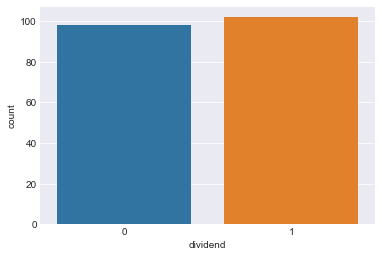

1    51.0
0    49.0
Name: dividend, dtype: float64


In [149]:
sns.countplot(data.dividend)
plt.show()
print((data.dividend.value_counts()/len(data)*100).round(2))

### We have almost balanced data.

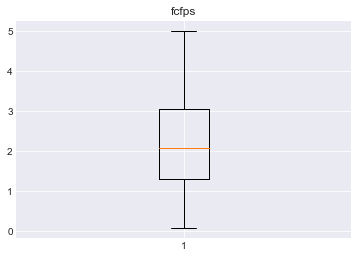

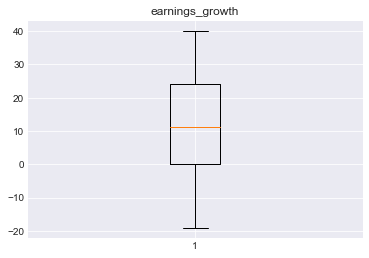

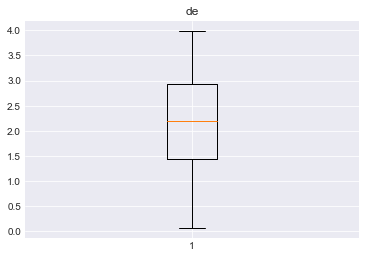

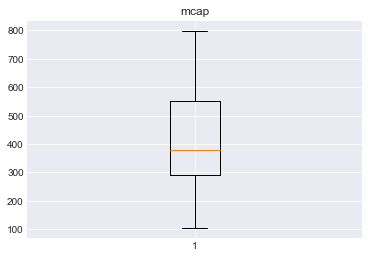

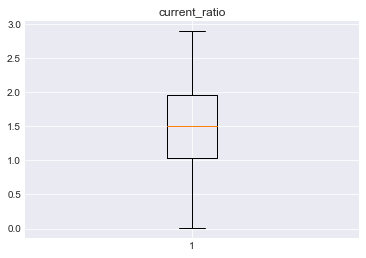

In [32]:
for i in data.iloc[:,1:6]:
  plt.boxplot(data[i])
  plt.title(i)
  plt.show()

### No outliers. 

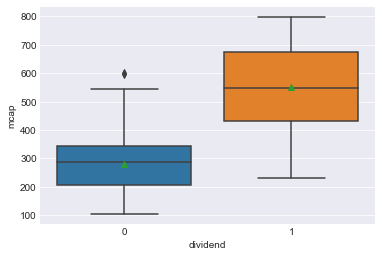

In [20]:
#let's see whether there is diiference in distribution of market capitalization by stocks which paid and didn't pay dividends
sns.set_style("darkgrid")
sns.boxplot(data.dividend,data.mcap,showmeans=True)
plt.show()

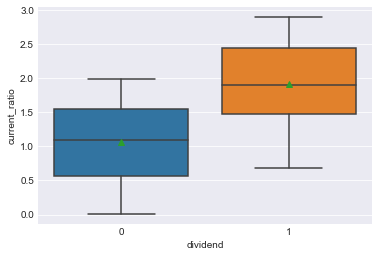

In [21]:
#let's see whether there is diiference in distribution of current ratio by stocks which paid and didn't pay dividends
sns.set_style("darkgrid")
sns.boxplot(data.dividend,data.current_ratio,showmeans=True)
plt.show()

### We saw that in both cases there are quite visibe differences of mean and median values of mcap and current_ratio for stocks which paid and didn't pay dividends.

C:\Users\HP\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


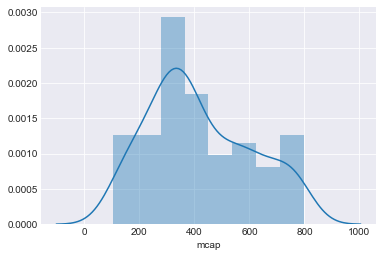

In [33]:
#plot the distribution using seaborn
sns.distplot(data.mcap)
plt.show()

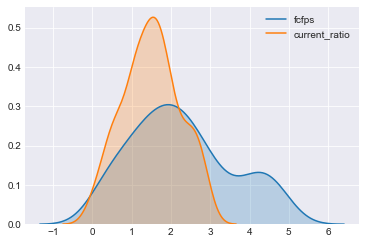

In [54]:
#kernel density estimation
for col in [data.fcfps,data.current_ratio]:
    sns.kdeplot(col, shade=True)

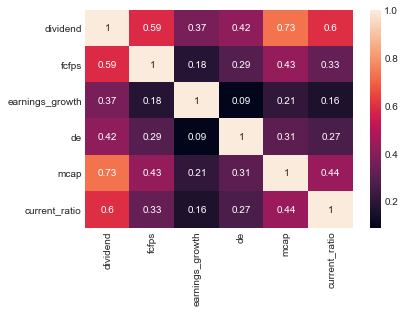

In [127]:
#Lets check for correlations
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

### No variables with correlation above 75%.

# Step 4. Transform data

### As we saw above that we have NAs, let's drop them.

In [56]:
data=data.dropna()
data.info() #now there are no outliers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 7 columns):
dividend           200 non-null int64
fcfps              200 non-null float64
earnings_growth    200 non-null float64
de                 200 non-null float64
mcap               200 non-null float64
current_ratio      200 non-null float64
country            200 non-null object
dtypes: float64(5), int64(1), object(1)
memory usage: 12.5+ KB


In [59]:
#let's devide into object and numeric datasets
data_object=data.select_dtypes(include="object")
data_numeric=data.select_dtypes(exclude="object")

In [67]:
#let's check number of uniques values of object variables
print([data_object[i].value_counts() for i in data_object.columns])

[EUR      71
US       71
Other    58
Name: country, dtype: int64]


In [72]:
#let's check for 0 variance of numeric variables
print(data_numeric.var()==0)

dividend           False
fcfps              False
earnings_growth    False
de                 False
mcap               False
current_ratio      False
dtype: bool


In [73]:
#let's conver object variables into dummies, join back datasets
#Do train-test split
data_dummies=pd.get_dummies(data_object,drop_first=True)
data_final=data_dummies.join(data_numeric)
X=data_final.drop("dividend",axis=1)
Y=data_final.dividend
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

# Step 5. Modeling

<b>Lets create 3 models: 
- Model 1-Logistic Regression from statsmodel
- Model 2-Logistic Regression from sklearn
- Model 3-Decision Tree Classification
</b>

<h3>Model 1.Logistic Regression from statsmodel </h3>

In [76]:
formula="dividend~"+"+".join(X.columns)
formula

'dividend~country_Other+country_US+fcfps+earnings_growth+de+mcap+current_ratio'

In [80]:
model1=Logit.from_formula(formula=formula,data=data_final).fit()

Optimization terminated successfully.
         Current function value: 0.089581
         Iterations 11


In [81]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               dividend   No. Observations:                  200
Model:                          Logit   Df Residuals:                      192
Method:                           MLE   Df Model:                            7
Date:                Thu, 29 Nov 2018   Pseudo R-squ.:                  0.8707
Time:                        01:33:48   Log-Likelihood:                -17.916
converged:                       True   LL-Null:                       -138.59
                                        LLR p-value:                 1.922e-48
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -25.9746      7.427     -3.498      0.000     -40.531     -11.419
country_Other       1.3084      1.091      1.200      0.230      -0.829       3.446
country_US          2.5355      1.400      1.812      0.070      -0.208       5.279
fcfps               2.2713      0.711      3.195      0.001       0.878       3.665
earnings_growth     0.1334      0.041      3.256      0.001       0.053       0.214
de                 -0.8549      0.540     -1.582      0.114      -1.914       0.204
mcap                0.0255      0.007      3.454      0.001       0.011       0.040
current_ratio       6.5094      2.223      2.928      0.003       2.152      10.867
===================================================================================

Possibly complete quasi-separation: A fraction 0.53 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### From the summary of the model, we see that there are 4 statistically significant variables (without intercept): 

In [125]:
print(model1.pvalues<=0.05)

Intercept           True
country_Other      False
country_US         False
fcfps               True
earnings_growth     True
de                 False
mcap                True
current_ratio       True
dtype: bool


### Let's get marginal effects to be able to interpret how much each variable changes the probability of paying dividend

In [129]:
model1.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:               dividend
Method:                          dydx
At:                           overall
===================================================================================
                     dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
country_Other       0.0359      0.029      1.257      0.209      -0.020       0.092
country_US          0.0697      0.035      2.007      0.045       0.002       0.138
fcfps               0.0624      0.013      4.802      0.000       0.037       0.088
earnings_growth     0.0037      0.001      5.443      0.000       0.002       0.005
de                 -0.0235      0.014     -1.668      0.095      -0.051       0.004
mcap                0.0007      0.000      5.901      0.000       0.000       0.001
current_ratio       0.1788      0.047      3.793      0.000       0.086       0.271
===================================================================================
"""

### Interpreting for categorical variable: US stocks have on average 6.97% higher probabilty of paying dividends compared to European stocks when other factors held constant.
### Interpreting for continous variable: Incremental increase in current ratio increases the probability of paying dividends on average by 17.88% when other factors held constant.  

## Model Fitting

In [151]:
#getting best parameters for Logit and DT
gridsearch1=GridSearchCV(LogisticRegression(random_state=42),param_grid={"penalty":["l1","l2"],"C":np.linspace(0.0001,50,20),
                                                                          "class_weight":["balanced", None]},
                                                            scoring="roc_auc",
                                                            cv=5,n_jobs=-1).fit(X,Y)
gridsearch2=GridSearchCV(DecisionTreeClassifier(random_state=42),param_grid={"max_depth":(5,15),"min_samples_leaf":(20,100),
                                                                             "class_weight":["balanced"]},
                                                                scoring="roc_auc",
                                                                cv=5,n_jobs=-1).fit(X,Y)

In [155]:
best1=list(gridsearch1.best_params_.values())
best2=list(gridsearch2.best_params_.values())
print("Best Parameters of Logit:",best1)
print("Best Parameters of DT:",best2)

Best Parameters of Logit: [21.052689473684207, 'balanced', 'l2']
Best Parameters of DT: ['balanced', 5, 20]


In [156]:
#Fitting models
logit=LogisticRegression(C=best1[0],penalty=best1[2],class_weight=best1[1],random_state=42).fit(x_train,y_train)
tree=DecisionTreeClassifier(class_weight=best2[0],random_state=42, max_depth=best2[1],
                            min_samples_leaf=best2[2]).fit(x_train,y_train)

## Model Evaluation 

### Confusion matrix

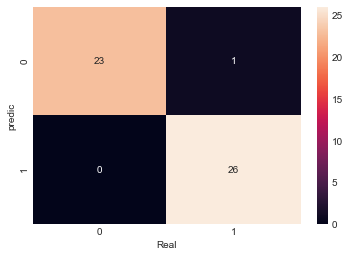

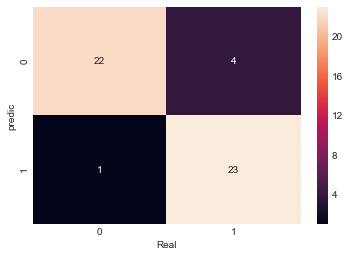

In [158]:
#let's print confusion matrix for logit and decision tree
for i in [logit,tree]:
    sns.heatmap(confusion_matrix(y_test,i.predict(x_test)).T,annot=True)
    plt.xlabel("Real")
    plt.ylabel("predic")
    plt.show()

### Classification_report

In [160]:
for i in [logit,tree]:
    print(classification_report(y_test,i.predict(x_test)))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        23
          1       1.00      0.96      0.98        27

avg / total       0.98      0.98      0.98        50

             precision    recall  f1-score   support

          0       0.85      0.96      0.90        23
          1       0.96      0.85      0.90        27

avg / total       0.91      0.90      0.90        50



###  Roc_AUC, Accuracy, Recall

In [163]:
for i in [logit,tree]:
    print("roc_auc=",roc_auc_score(y_test,i.predict(x_test))*100)
for i in [logit,tree]:
    print("recall=",recall_score(y_test,i.predict(x_test))*100)
for i in [logit,tree]:
    print("accuracy train=",i.score(x_train,y_train)*100) 
for i in [logit,tree]:
    print("accuracy test=",i.score(x_test,y_test)*100)

roc_auc= 98.14814814814814
roc_auc= 90.41867954911433
recall= 96.29629629629629
recall= 85.18518518518519
accuracy train= 95.33333333333334
accuracy train= 87.33333333333333
accuracy test= 98.0
accuracy test= 90.0


### Avereage cross validation roc_auc

In [193]:
print("Logit Avereage cross validation roc_auc:", gridsearch1.best_score_)
print("Tree Avereage cross validation roc_auc:", gridsearch2.best_score_)

Logit Avereage cross validation roc_auc: 0.9931428571428572
Tree Avereage cross validation roc_auc: 0.9316851503759398


### ROC Curve

### Logit

In [178]:
FPR,TPR,tresholds=roc_curve(y_test,logit.predict_proba(x_test)[:,1])
print(FPR,TPR)

[0.         0.         0.08695652 0.08695652 1.        ] [0.03703704 0.96296296 0.96296296 1.         1.        ]


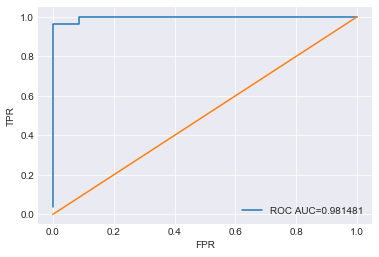

In [179]:
plt.plot(FPR,TPR,label="ROC AUC=%f"%roc_auc_score(y_test,logit.predict(x_test)))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Tree

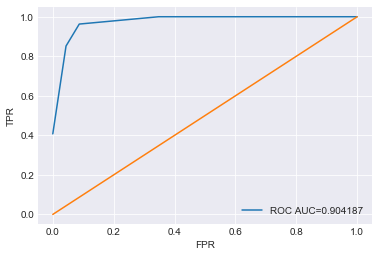

In [192]:
FPR1,TPR1,tresholds1=roc_curve(y_test,tree.predict_proba(x_test)[:,1])
plt.figure(figsize=(6,4))
plt.plot(FPR1,TPR1,label="ROC AUC=%f"%roc_auc_score(y_test,tree.predict(x_test)))
plt.plot([0,1],[0,1])
plt.legend(loc="lower right")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()